<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Graphs in NLP</h1>
        <h1>Word Networks for Language Generation</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

We start by print out the versions of the libraries we're using for future reference

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import gzip
import zipfile

import seaborn as sns

import nltk 
from nltk.corpus import stopwords

import matplotlib
import matplotlib.pyplot as plt 

import os
import re
import tqdm as tq
from tqdm import tqdm
tqdm.pandas()

import networkx as nx

import sklearn
from sklearn.linear_model import LinearRegression

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: ae69fdf6632e9262d6c543a7940bbe63db46fb44

networkx  : 2.5
re        : 2.2.1
seaborn   : 0.11.0
pandas    : 1.1.3
nltk      : 3.5
tqdm      : 4.50.2
json      : 2.0.9
watermark : 2.1.0
numpy     : 1.19.2
matplotlib: 3.3.2
sklearn   : 0.23.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Extract 2-grams from data

Extracting 2-grams from a piece of text is simple. Let us take a simple example

In [4]:
text = 'Mary had a little lamb little lamb little lamb'

We extract individual words using a simple regex

In [5]:
text_regex = re.compile(r"[a-zA-Z]+")
words = text_regex.findall(text)

And now we just have to combine neighboring words into 2-grams

In [6]:
ngrams = []

for i in range(len(words)-1):
    ngrams.append((words[i], words[i+1]))
    
ngrams

[('Mary', 'had'),
 ('had', 'a'),
 ('a', 'little'),
 ('little', 'lamb'),
 ('lamb', 'little'),
 ('little', 'lamb'),
 ('lamb', 'little'),
 ('little', 'lamb')]

And we can compute the weights and build out the edge_list

In [7]:
edge_list = pd.DataFrame([[edge[0], edge[1], weight] for edge, weight in Counter(ngrams).items()], 
                         columns=['node_i', 'node_j', 'weight'])

edge_list

,node_i,node_j,weight
0,Mary,had,1
1,had,a,1
2,a,little,1
3,little,lamb,3
4,lamb,little,2


Fortunately, Google already did all this work for us...

# Process Google Books 2-gram data

The full dataset is over 27Gb so I've already done this for you and saved it as a relatively small file (~500Mb)... You can download it from this [Google Drive link](https://drive.google.com/file/d/1vX5qi_GqiN4-PYTHqamWZAvbkUq0xFue/view?usp=sharing) (Save it under the repo's data folder or update the filename below) but just in case you want the code to process the original files

In [8]:
filename = "data/2-gram_full.dat.gz"

# If we don't have the processed file
if not os.path.exists(filename):
    edges = {}
    
    text = re.compile(r"^[a-zA-Z]+$")
    
    # Go through the list of 2-gram files from google books
    for url in tqdm(open("data/2-grams.txt", "rt"), total=100):
        filename = os.path.basename(url.strip())
        localfile = os.path.join('data', '2-grams', filename)
        
        # If we don't already have it, download it
        # Depending on your internet connection this might take a while...
        # and you should make sure that the "2-grams" directory exists
        if not os.path.exists(localfile):
            wget.download(url, out='data/2-grams')
        
        # Process it, line by line
        with zipfile.ZipFile(localfile) as zf:
            # About 3m per file in my MBP, about 6h total 
            with zf.open(filename[:-4], 'r') as fp:
                for line in fp:
                    fields = line.decode('utf8').strip().split()
                    year = int(fields[2])

                    word1 = fields[0].lower().strip()
                    word2 = fields[1].lower().strip()
                    count = int(fields[3])

                    # Make sure we have two words with just letters
                    if  text.match(word1) is not None and text.match(word2) is not None:
                        edge = (word1, word2)

                        edges[edge] = edges.get(edge, 0) + count
    
    new_edges = {}
    
    # Write down the edges
    with gzip.open(filename, "wt") as fp:
        print('node_i', 'node_j', 'weight', file=fp)
        
        for edge in tqdm(edges, total=len(edges)):
            print(edge[0], edge[1], edges[edge], file=fp)
            new_edges[edge] = edges[edge]
    
    del new_edges
    del edges

edges = pd.read_csv(filename, sep=' ')

Now that we have loaded our edges, we can start analyzing our network. First we check how many nodes we have. We can extract this information by combining the sets of nodes mentioned in the edge list. In total we have over 1.7M nodes

In [9]:
N = len(set(edges['node_i'].unique()) | set(edges['node_j'].unique()))
print(N)

1720174


And over 70 million edges (2-grams)

In [10]:
edges.shape[0]

70387456

In total, the English Google Books dataset contains 235 Billion word pairs

In [11]:
edges['weight'].sum()

235519098368

## Node degrees

Since we have a network, we can check what the in and out degree distributions look like. To get the in and out degrees we just need to count the number of unique in and out edges. Pandas makes this particularly easy.

In [12]:
degree_out = edges[['node_i', 'node_j']].groupby('node_i').count()
degree_in = edges[['node_i', 'node_j']].groupby('node_j').count()

Conceptually, these are just dictionaries mapping each node to how many other nodes it is connected to

In [13]:
degree_out.head()

,node_j
node_i,
a,256131
aa,4163
aaa,603
aaaa,46
aaaaa,20


For visualization purposes we write a simple function to calculate the distribution from a sequence of values

In [14]:
def prob_dist(values, resolution=1, normed=True):
    counts = Counter((1+np.round(values.flatten()/resolution))*resolution)
    
    counts = pd.DataFrame(np.array(list(counts.items())))
    counts = counts.sort_values(0)    
    
    if normed:
        counts[1] /= counts[1].sum()
    
    return counts

The degree distributions are then

In [15]:
K_out = prob_dist(degree_out.values, 1)
K_in = prob_dist(degree_in.values, 1)

Which we can easily plot

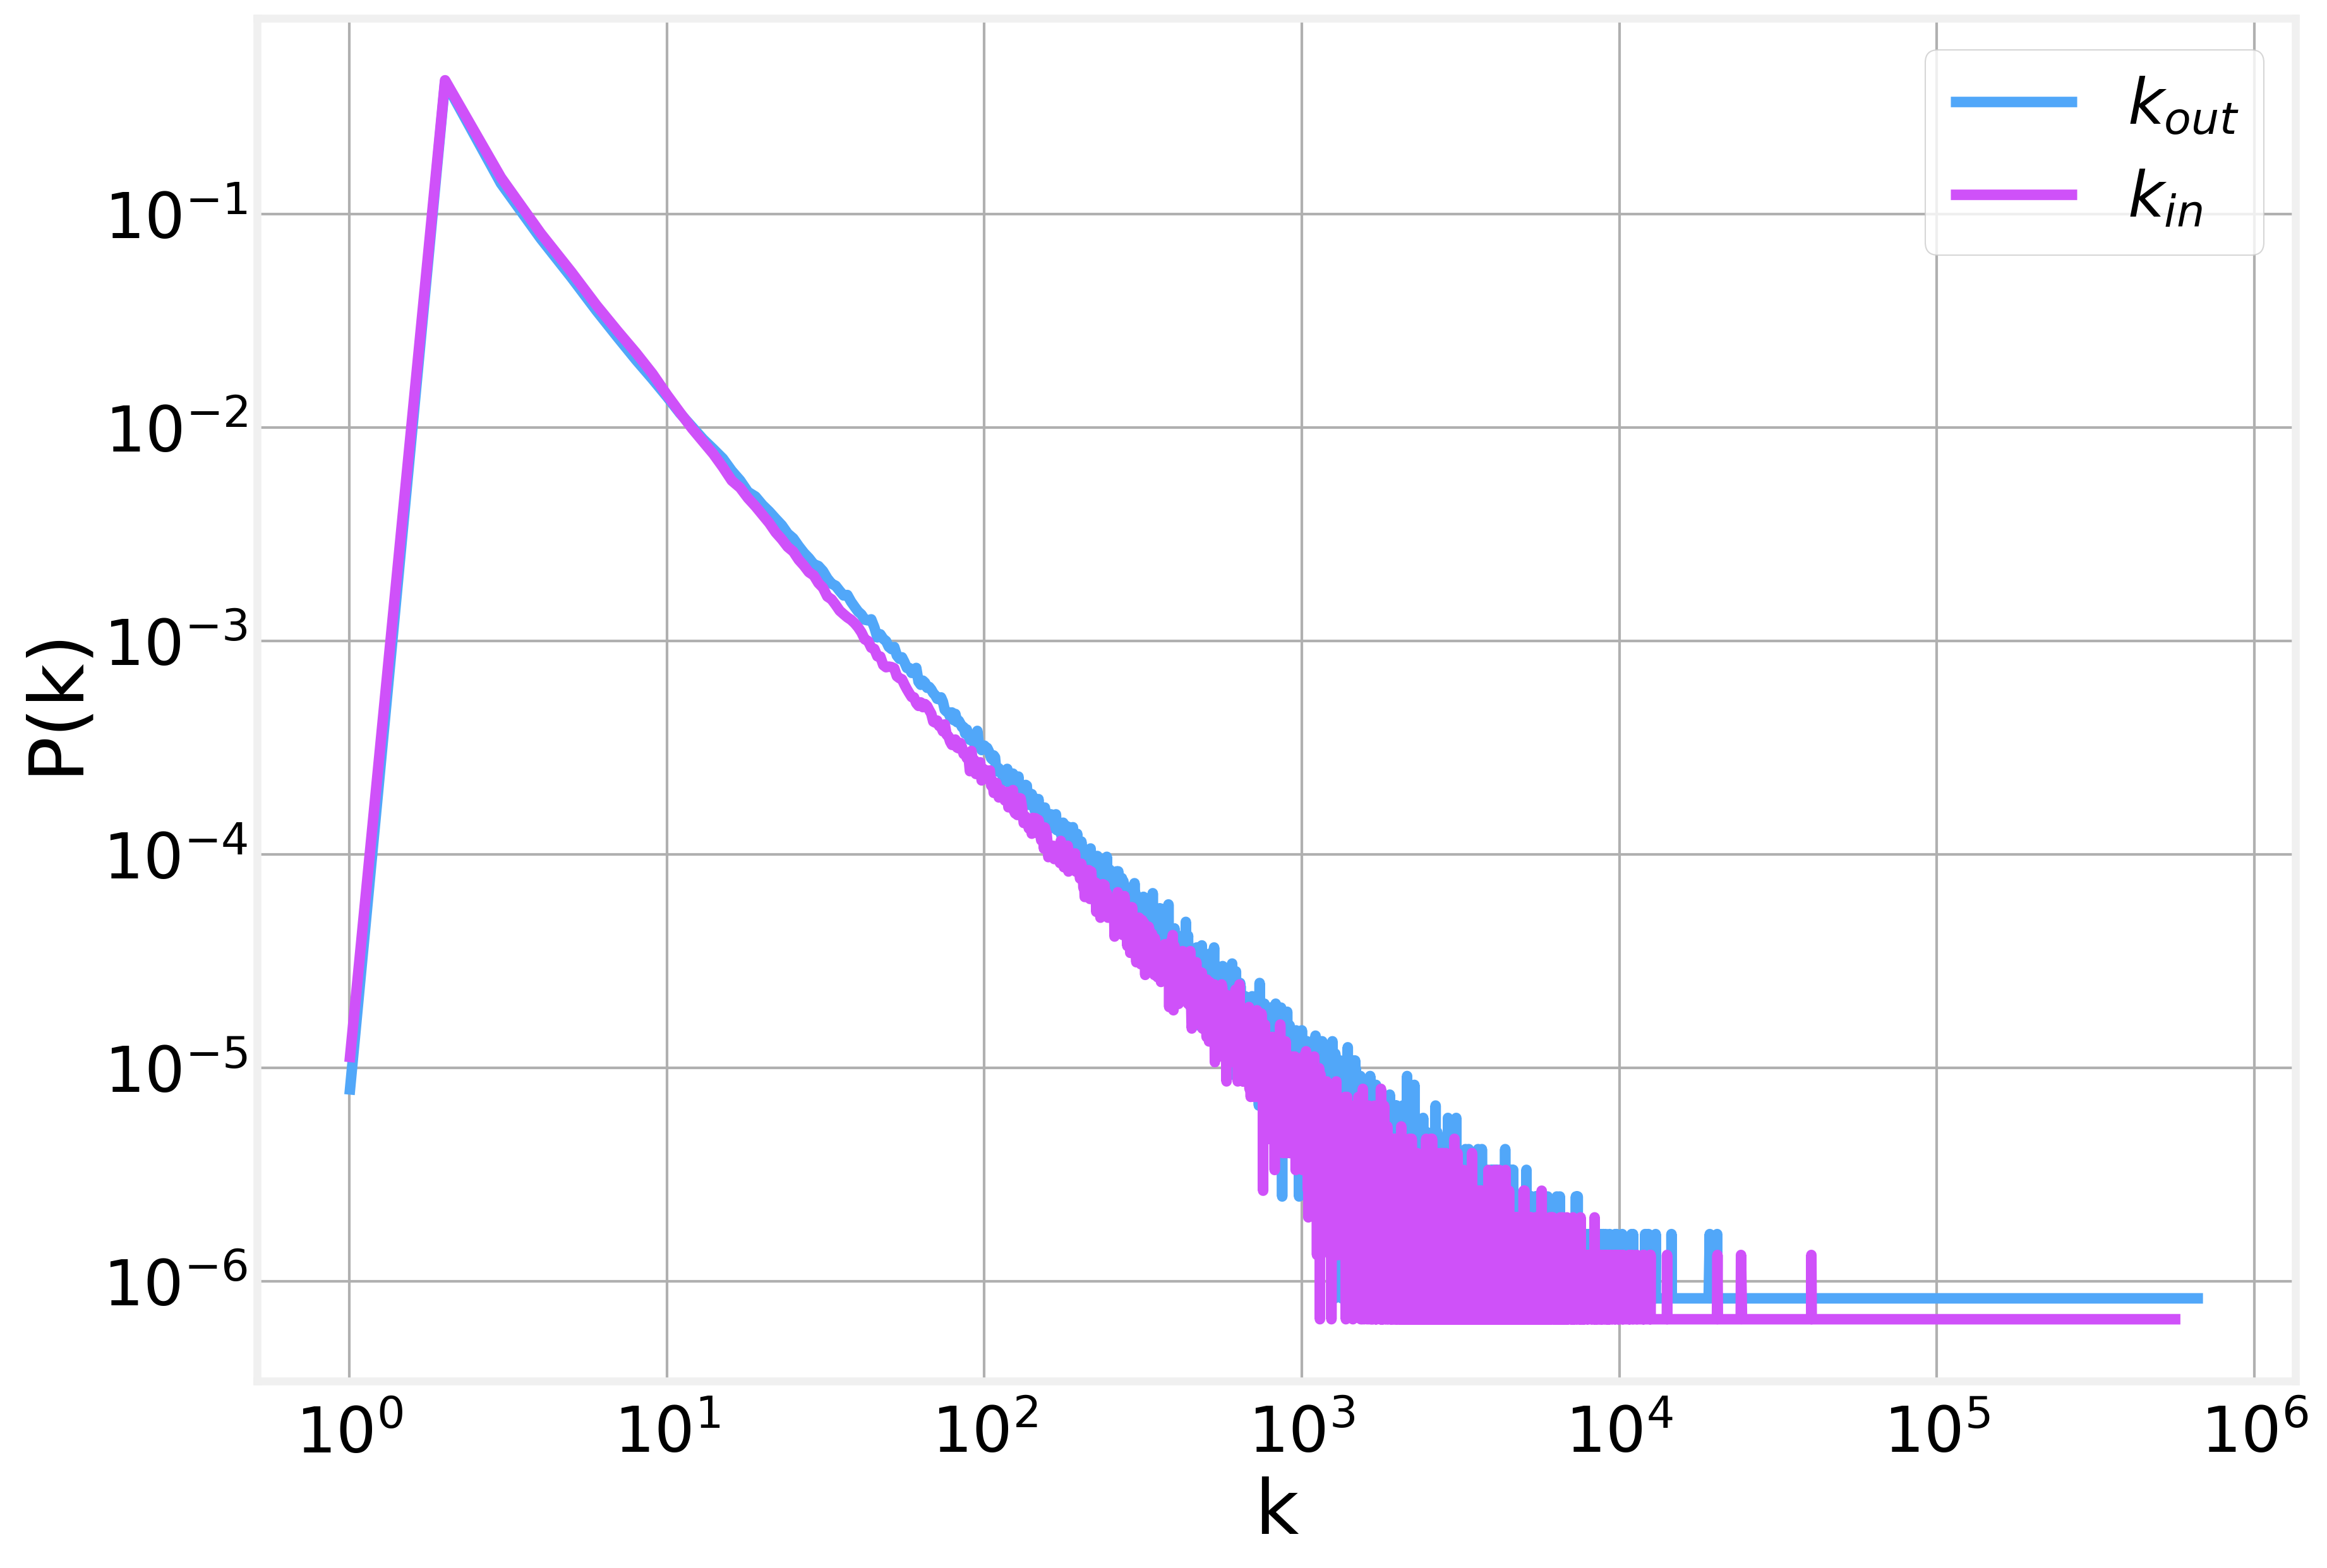

In [16]:
ax = K_out.plot(x=0, y=1, logy=True, logx=True, label=r'$k_{out}$')
K_in.plot(x=0, y=1, logy=True, logx=True, ax=ax, label=r'$k_{in}$')
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel('P(k)')

for label in ax.xaxis.get_majorticklabels():
    label.set_y(-.01)

plt.gcf().tight_layout()

Here we note a few important points. 

- $P(k_{in})$ and $P(k_{out})$ are fairly similar. This is to be expected as one nodes outgoing edge must be another nodes incoming edge.
- The distributions are power-law (ish) with a broad right tail. This implies that some nodes have huge degrees (almost 1 million) while most nodes have almost no connections
- A few words have in/out-degree of 1. This likely corresponds to (unusual) typos

In [17]:
degree_in[degree_in['node_i'] <= 2]

,node_i
node_j,
aaaah,1
aaaahs,1
aaaai,1
aaabab,1
aaac,1
...,...
zzril,1
zztgx,1
zzw,2


In [18]:
degree_out[degree_out['node_j'] <= 2]

,node_j
node_i,
aaaai,1
aaab,1
aaaf,1
aaah,1
aaahed,1
...,...
zzd,2
zznl,1
zzril,1


The most likely degree for a word is 2:

In [19]:
K_in.set_index(0).idxmax()

1    2.0
dtype: float64

Which are also pretty uncommon...

In [20]:
degree_in[degree_in['node_i'] == 2]

,node_i
node_j,
aaad,2
aaalac,2
aabe,2
aaberge,2
aaboe,2
...,...
zyxin,2
zyzanski,2
zyzzyva,2


On the other hand, words with the highest degree values are interesting.

In [21]:
degree_in.sort_values('node_i', ascending=False).head(20)

,node_i
node_j,
and,585260
in,360672
of,325205
to,262199
is,239546
was,217736
or,182749
the,179655
as,161512


In [22]:
degree_out.sort_values('node_j', ascending=False).head(10)

,node_j
node_i,
the,689422
and,602357
of,555368
to,278294
in,275767
a,256131
by,229717
or,201258
as,185124


In fact, we note that the words with the highers in/out degree tend to be the same as we confirm when we look at the Pearson correlation between in/out degree.

In [23]:
node_info = degree_in.join(degree_out, how='outer').fillna(0).sort_values('node_i', ascending=False).copy()
node_info.columns=['kin', 'kout']

In [24]:
corr = node_info.corr()
corr.rename(columns={'kin': r'$k_{in}$', 
                    'kout': r'$k_{out}$'}, inplace=True)
corr.rename(index={'kin': r'$k_{in}$', 
                    'kout': r'$k_{out}$'}, inplace=True)

<AxesSubplot:>

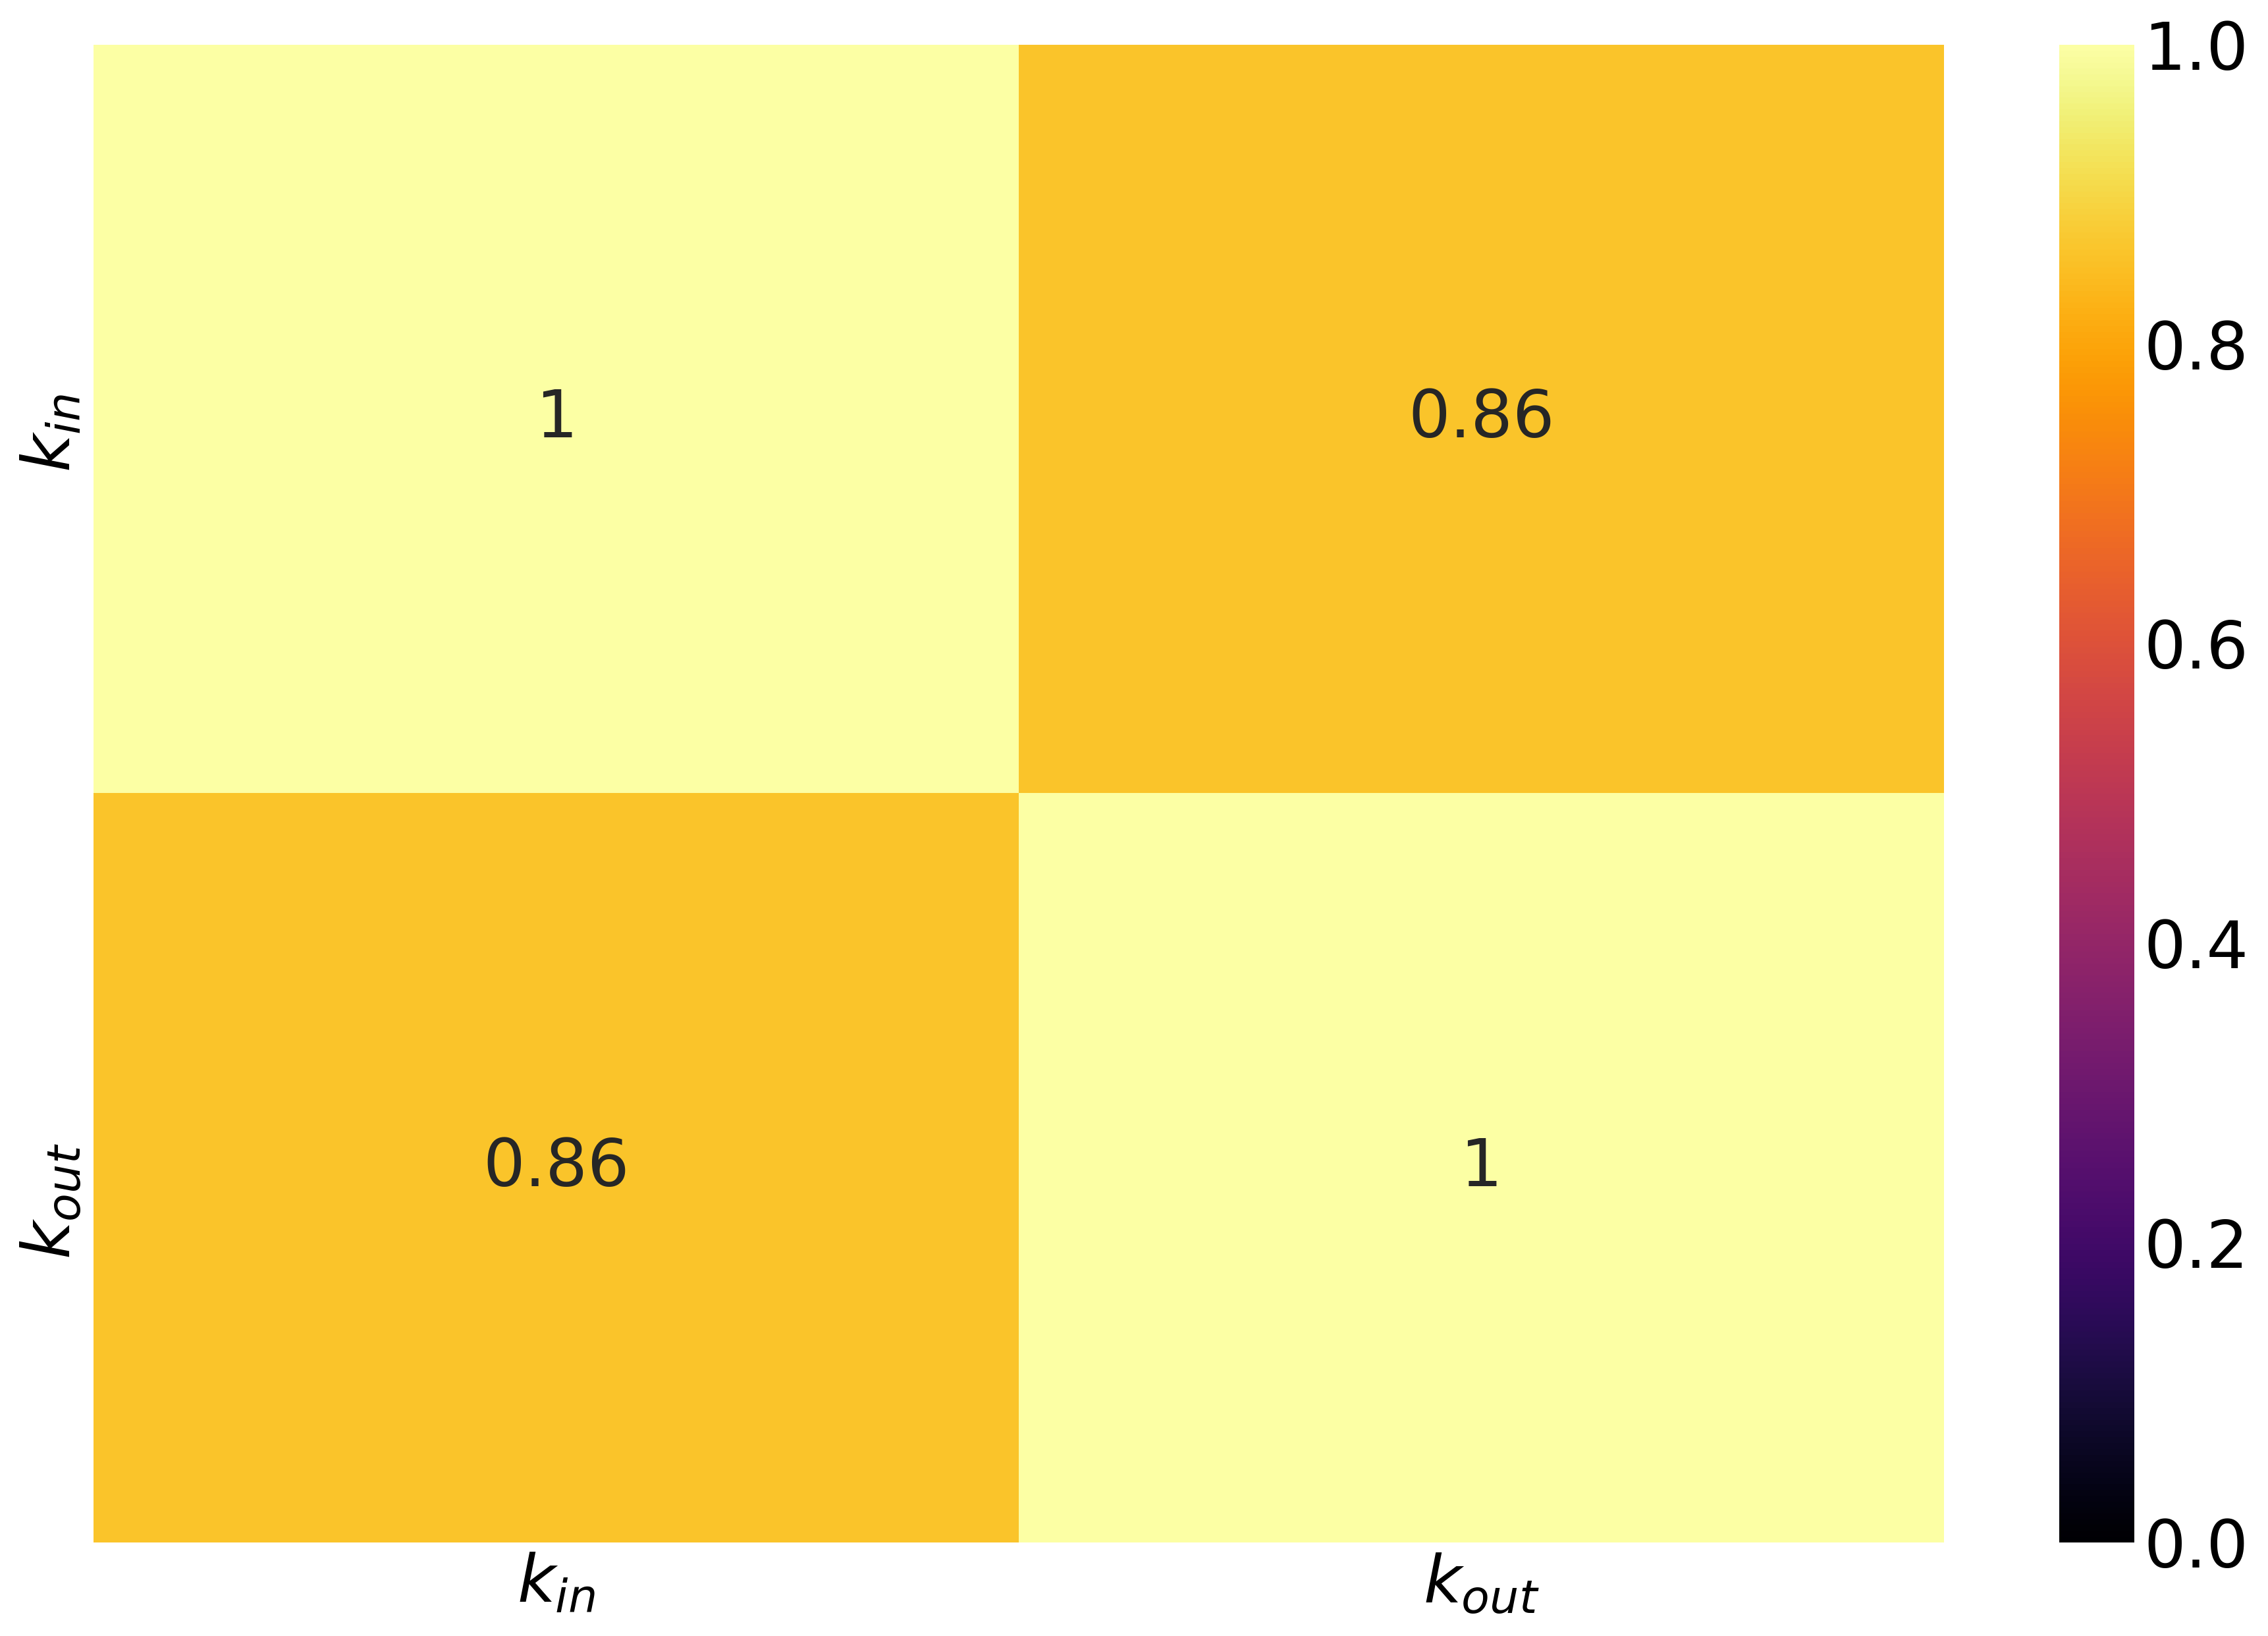

In [25]:
sns.heatmap(corr.round(2), vmin=0, vmax=1, annot=True, cmap=plt.cm.inferno)

A correlation of 0.86 is pretty larger and we make it evern clearer with a linear regression

In [26]:
lm = LinearRegression()
lm.fit(node_info[['kin']], node_info[['kout']])

LinearRegression()

A slope of 1 is another pretty clear indication that the two degrees are strongly correlated

In [27]:
lm.coef_

array([[1.00918683]])

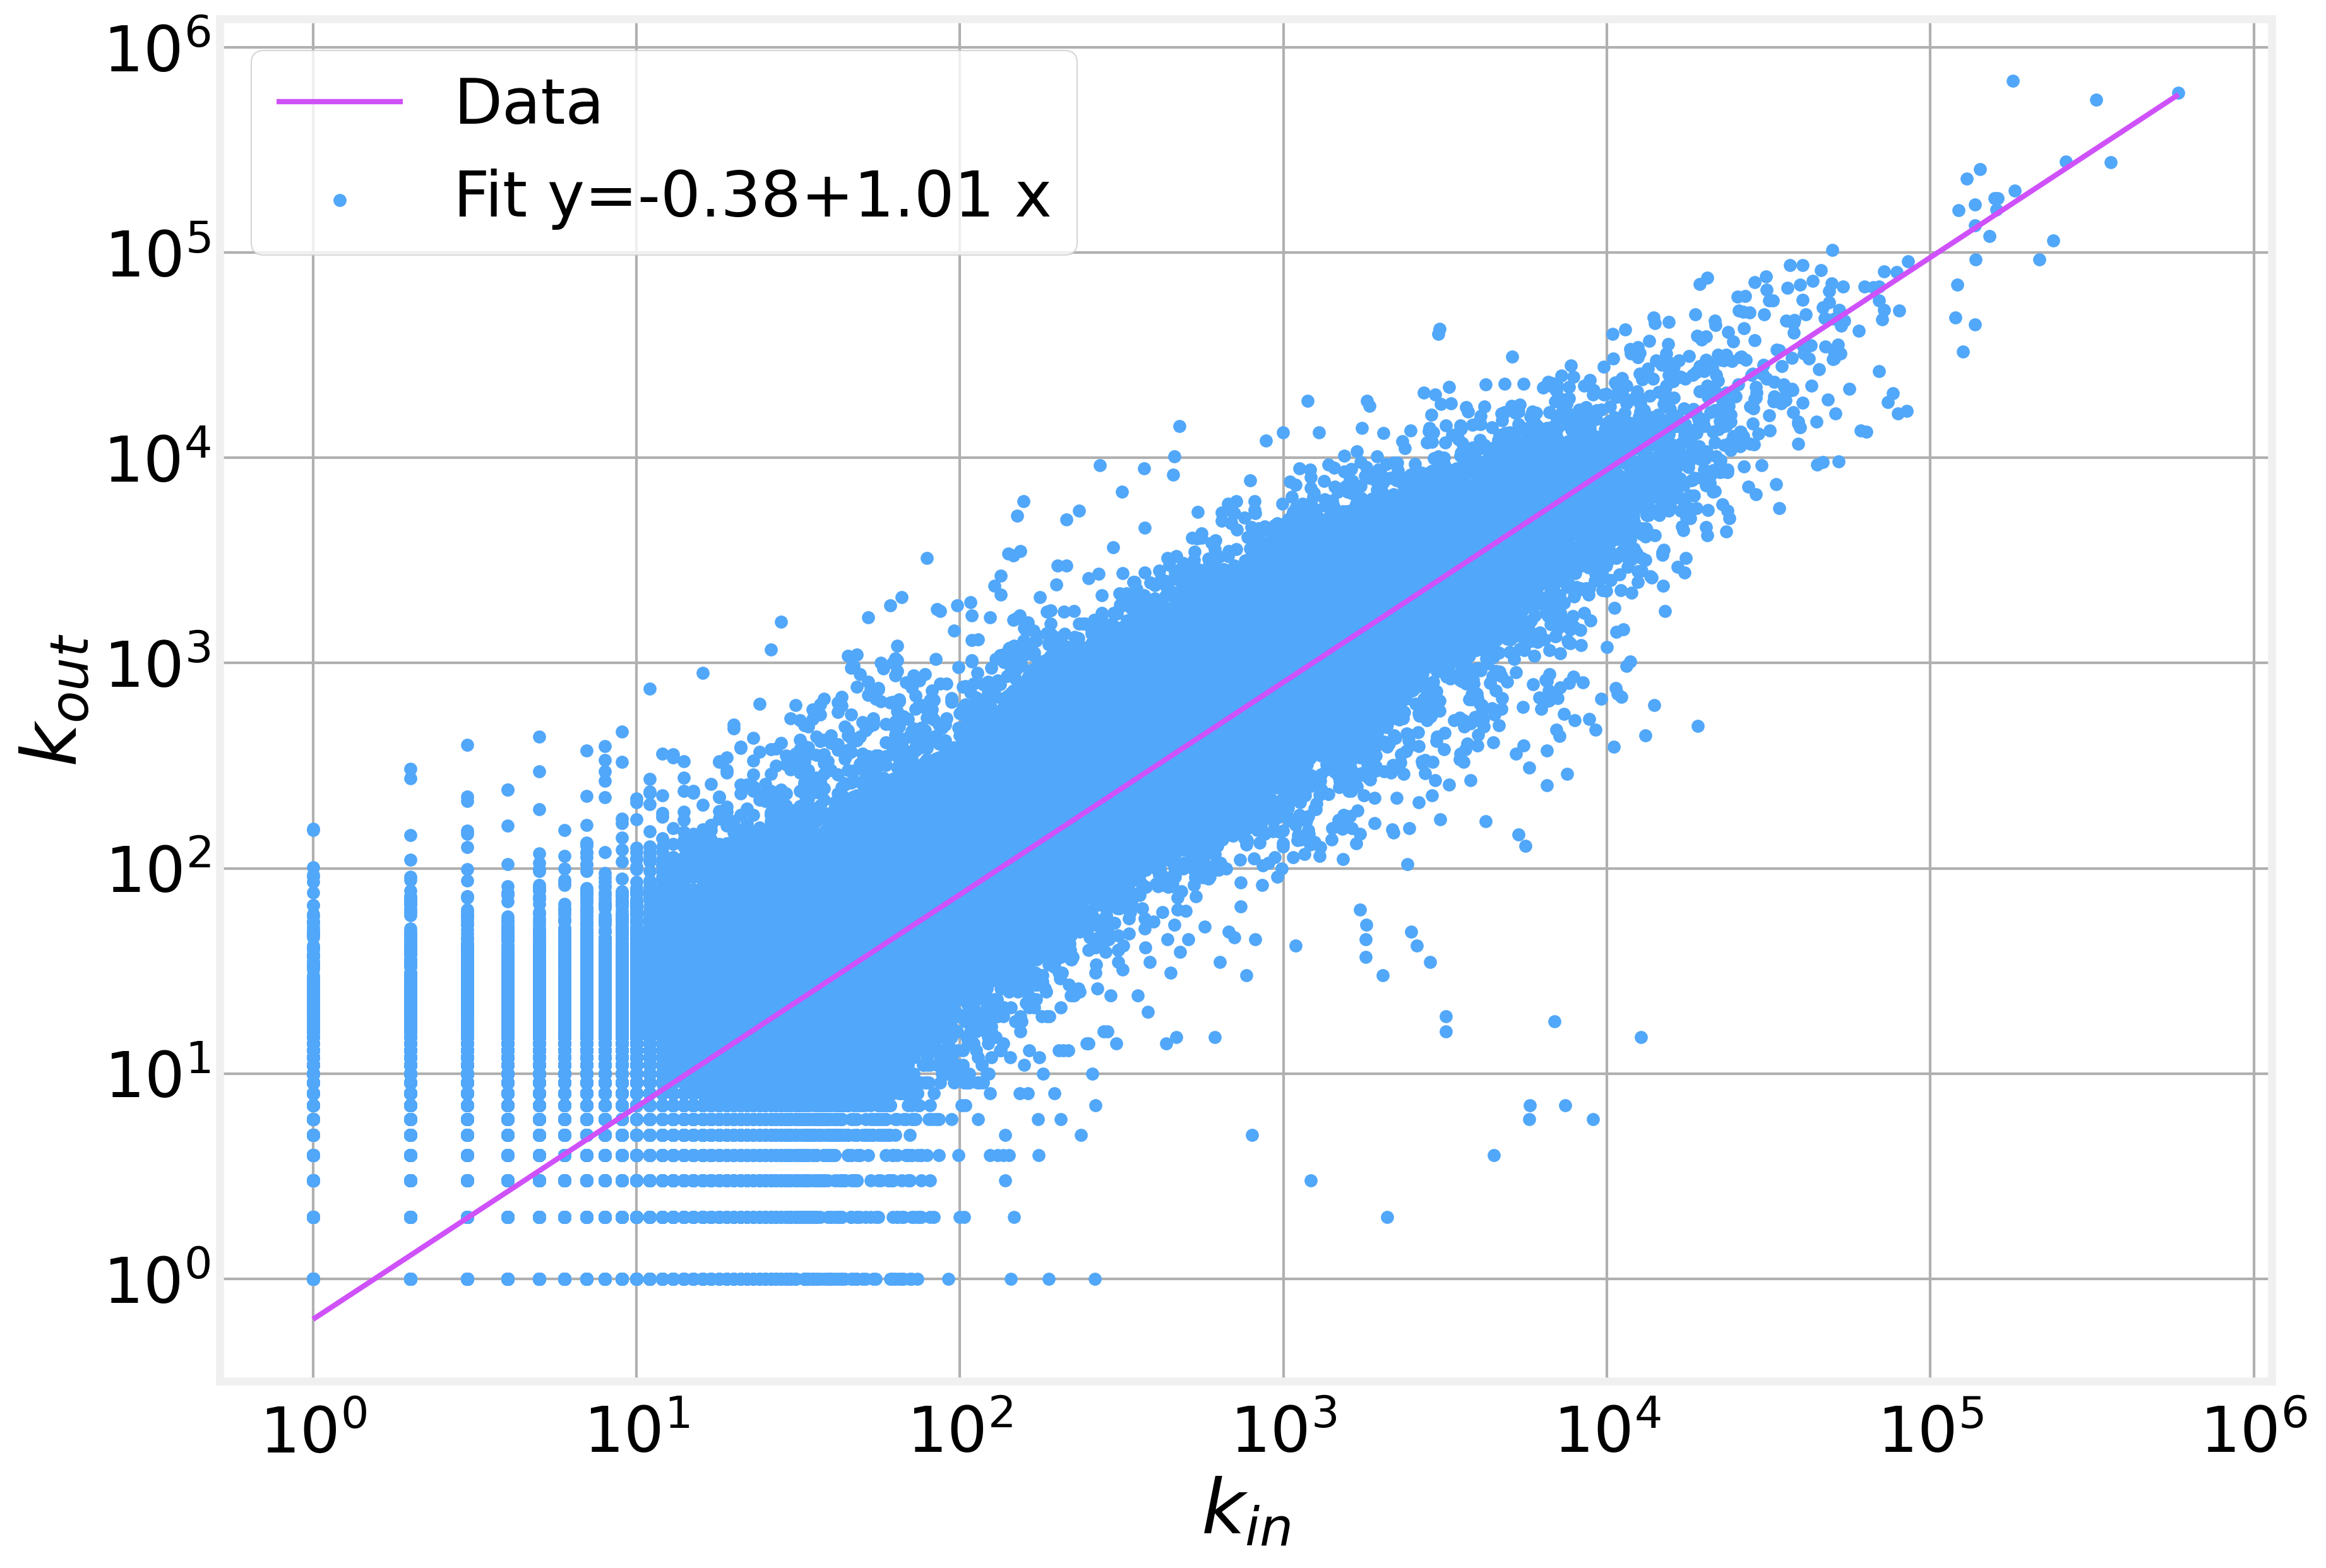

In [28]:
ax = node_info.plot.scatter(x='kin', y='kout')

krange = np.array([node_info[['kin']].max(), node_info[['kin']].min()+1])
pred = lm.predict(krange)
ax.loglog(krange, pred, '-', color=colors[1], lw=2)

ax.set_xlabel(r'$k_{in}$')
ax.set_ylabel(r'$k_{out}$')

for label in ax.xaxis.get_majorticklabels():
    label.set_y(-.01)

ax.legend(['Data', 'Fit y=%1.2f+%1.2f x' % (lm.intercept_[0], lm.coef_[0])])

Let's take a look at the most common words

In [29]:
topwords = node_info.copy()
topwords['dist'] = np.sqrt(topwords['kin']**2+topwords['kout']**2)
topwords.sort_values('dist', ascending=False).head(20)

,kin,kout,dist
and,585260.0,602357.0,839859.049513
the,179655.0,689422.0,712445.515888
of,325205.0,555368.0,643577.429257
in,360672.0,275767.0,454017.323318
to,262199.0,278294.0,382355.680011
a,142493.0,256131.0,293099.546588
or,182749.0,201258.0,271849.185331
is,239546.0,115148.0,265784.401386
by,129913.0,229717.0,263907.725650
as,161512.0,185124.0,245676.660511


When we look at this list we note that these words appear to be stopwords. We confirm this by loading up a list of stopwords from NLTK

In [30]:
stop_en = stopwords.words('english')
overlap = set(stop_en) & set(node_info.index)

NLTK uses 179 stopwords, 153 of which are part of our dataset

In [31]:
print("NLTK words:", len(stop_en))
print("Dataset:", len(overlap))

NLTK words: 179
Dataset: 153


These words all have a pretty high mean degree, placing them well into the tail of our distribution

In [32]:
pd.DataFrame(node_info.loc[overlap].mean().round(0))

,0
kin,53011.0
kout,56760.0


But what about the 26 words we __don't__ see in our data?

In [33]:
missing = set(stop_en) - set(node_info.index)
missing

{"aren't",
 "couldn't",
 "didn't",
 "doesn't",
 "don't",
 "hadn't",
 "hasn't",
 "haven't",
 "isn't",
 "it's",
 "mightn't",
 "mustn't",
 "needn't",
 "shan't",
 "she's",
 "should've",
 "shouldn't",
 "that'll",
 "wasn't",
 "weren't",
 "won't",
 "wouldn't",
 "you'd",
 "you'll",
 "you're",
 "you've"}

These are all contractions of two words, so we see them popping up in our original 2-gram dataset

In [34]:
edges[(edges['node_i'] == 'aren') & (edges['node_j'] == 't')]

,node_i,node_j,weight
35019650,aren,t,1841


## Edge weights

In [35]:
edges.sort_values('weight', ascending=False, inplace=True)
edges.head(20)

,node_i,node_j,weight
8223473,of,the,3243999909
973562,in,the,1753160117
9206022,to,the,1072859611
14931367,and,the,726576725
156926,on,the,645591979
8414488,to,be,506837334
17678123,for,the,500180793
105381,it,is,488758757
6835129,by,the,464390971
9439188,of,a,452357485


The distribution of edge weights is pretty broad spanning 9 orders of magnitude

In [36]:
Pw = prob_dist(edges['weight'].values)

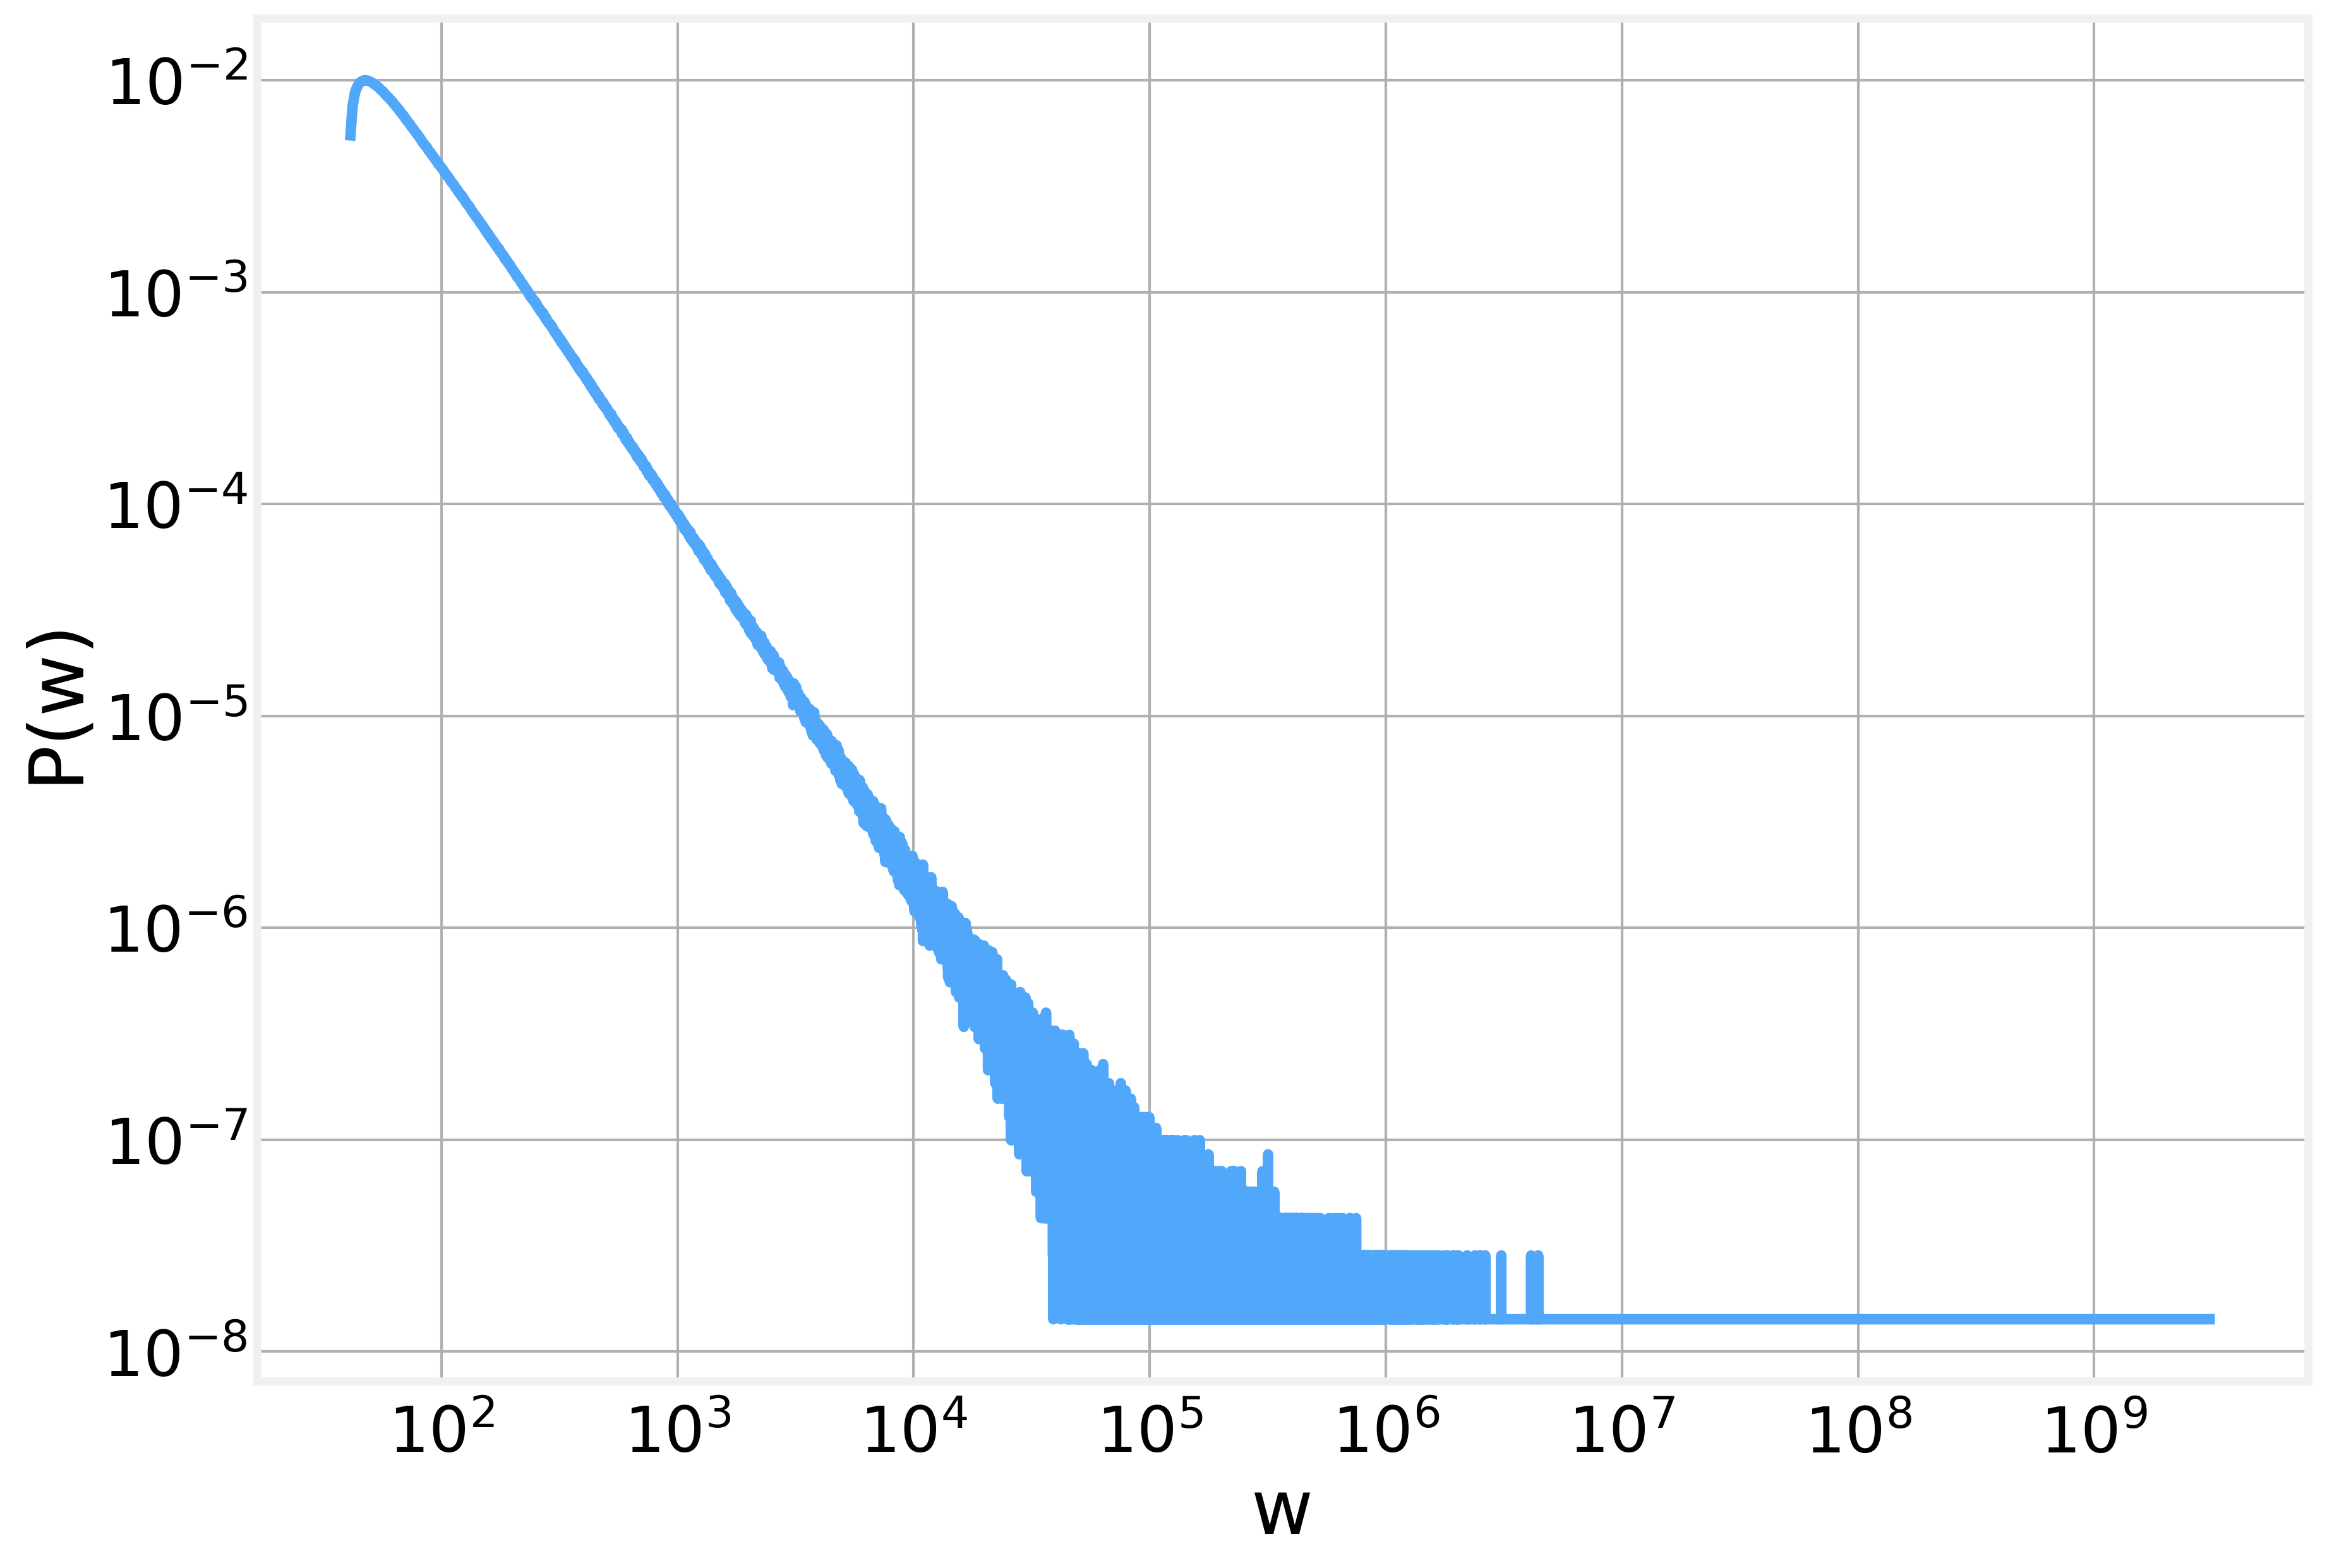

In [37]:
ax = Pw.plot(x=0, y=1, logy=True, logx=True, legend=None)
ax.set_xlabel('w')
ax.set_ylabel('P(w)')

for label in ax.xaxis.get_majorticklabels():
    label.set_y(-.01)

plt.gcf().tight_layout()

As in the case of the degree distributions, most of the edges have relatively small weights. 

The Google Books dataset contains books published as far back as the 1500s and with extensive coverage since 1800. If we set a weight threshold of 1000 (roughly 5 occurrences per year between 1800-2000, we have just 8.5 million edges left

In [38]:
edges_small = edges[edges['weight'] >= 1000].dropna().copy()

A reduction of 88% in size!

In [39]:
edges_small.shape[0]/edges.shape[0]

0.12106054806129092

We save this reduced file for later analysis

In [40]:
if not os.path.exists('data/2-gram.dat.gz'):
    edges_small.to_csv('data/2-gram.dat.gz', sep=' ', index=False)

And we can easily check that the weight distribution is simply truncated

In [41]:
Pw_small = prob_dist(edges_small['weight'].values)

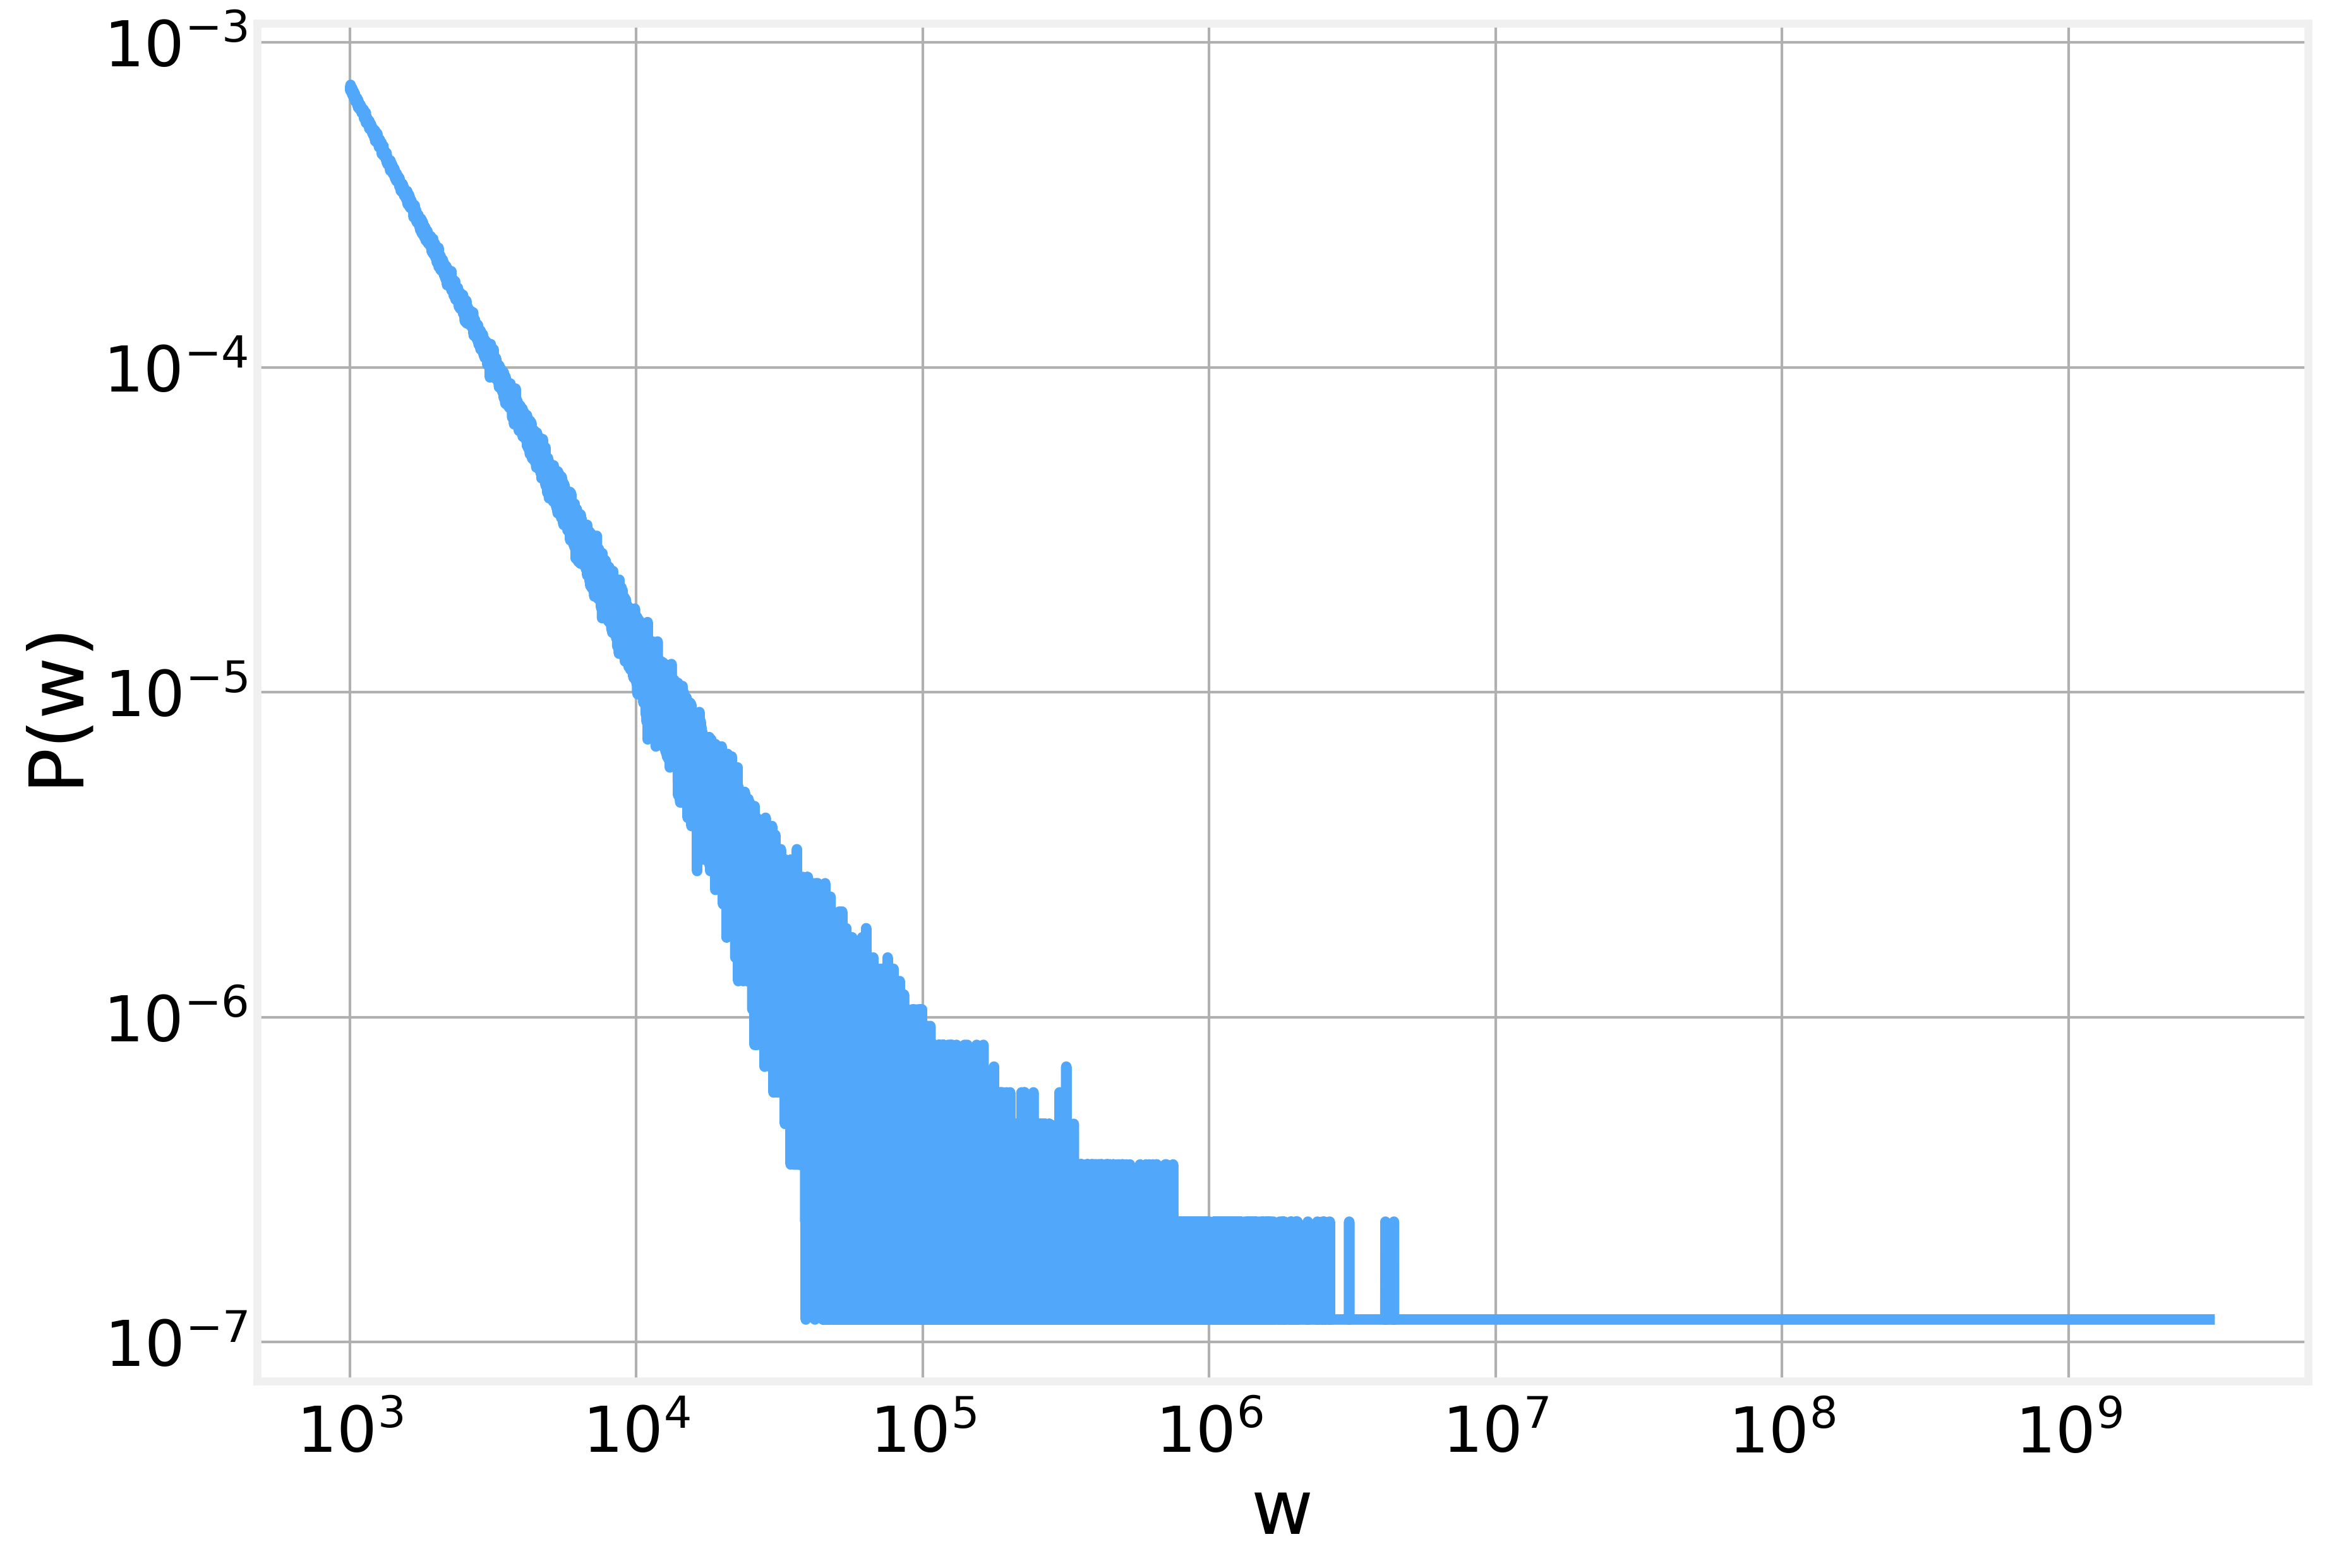

In [42]:
ax = Pw_small.plot(x=0, y=1, logy=True, logx=True, legend=None)
ax.set_xlabel('w')
ax.set_ylabel('P(w)')

for label in ax.xaxis.get_majorticklabels():
    label.set_y(-.01)

plt.gcf().tight_layout()

## Node strength

Continuing for now with the original file, we take a look at the node strenghts. Strenght is simply the weighted equivalent of the degree where each edge counts it's weight instead of just 1.

In [43]:
strength_out = edges[['node_i', 'weight']].groupby(['node_i']).sum()
strength_in = edges[['node_j', 'weight']].groupby(['node_j']).sum()

The distribution is broad tailed as expected, but over a much wider range than the degree distribution

In [44]:
S_out = prob_dist(strength_out.values, 1)
S_in = prob_dist(strength_in.values, 1)

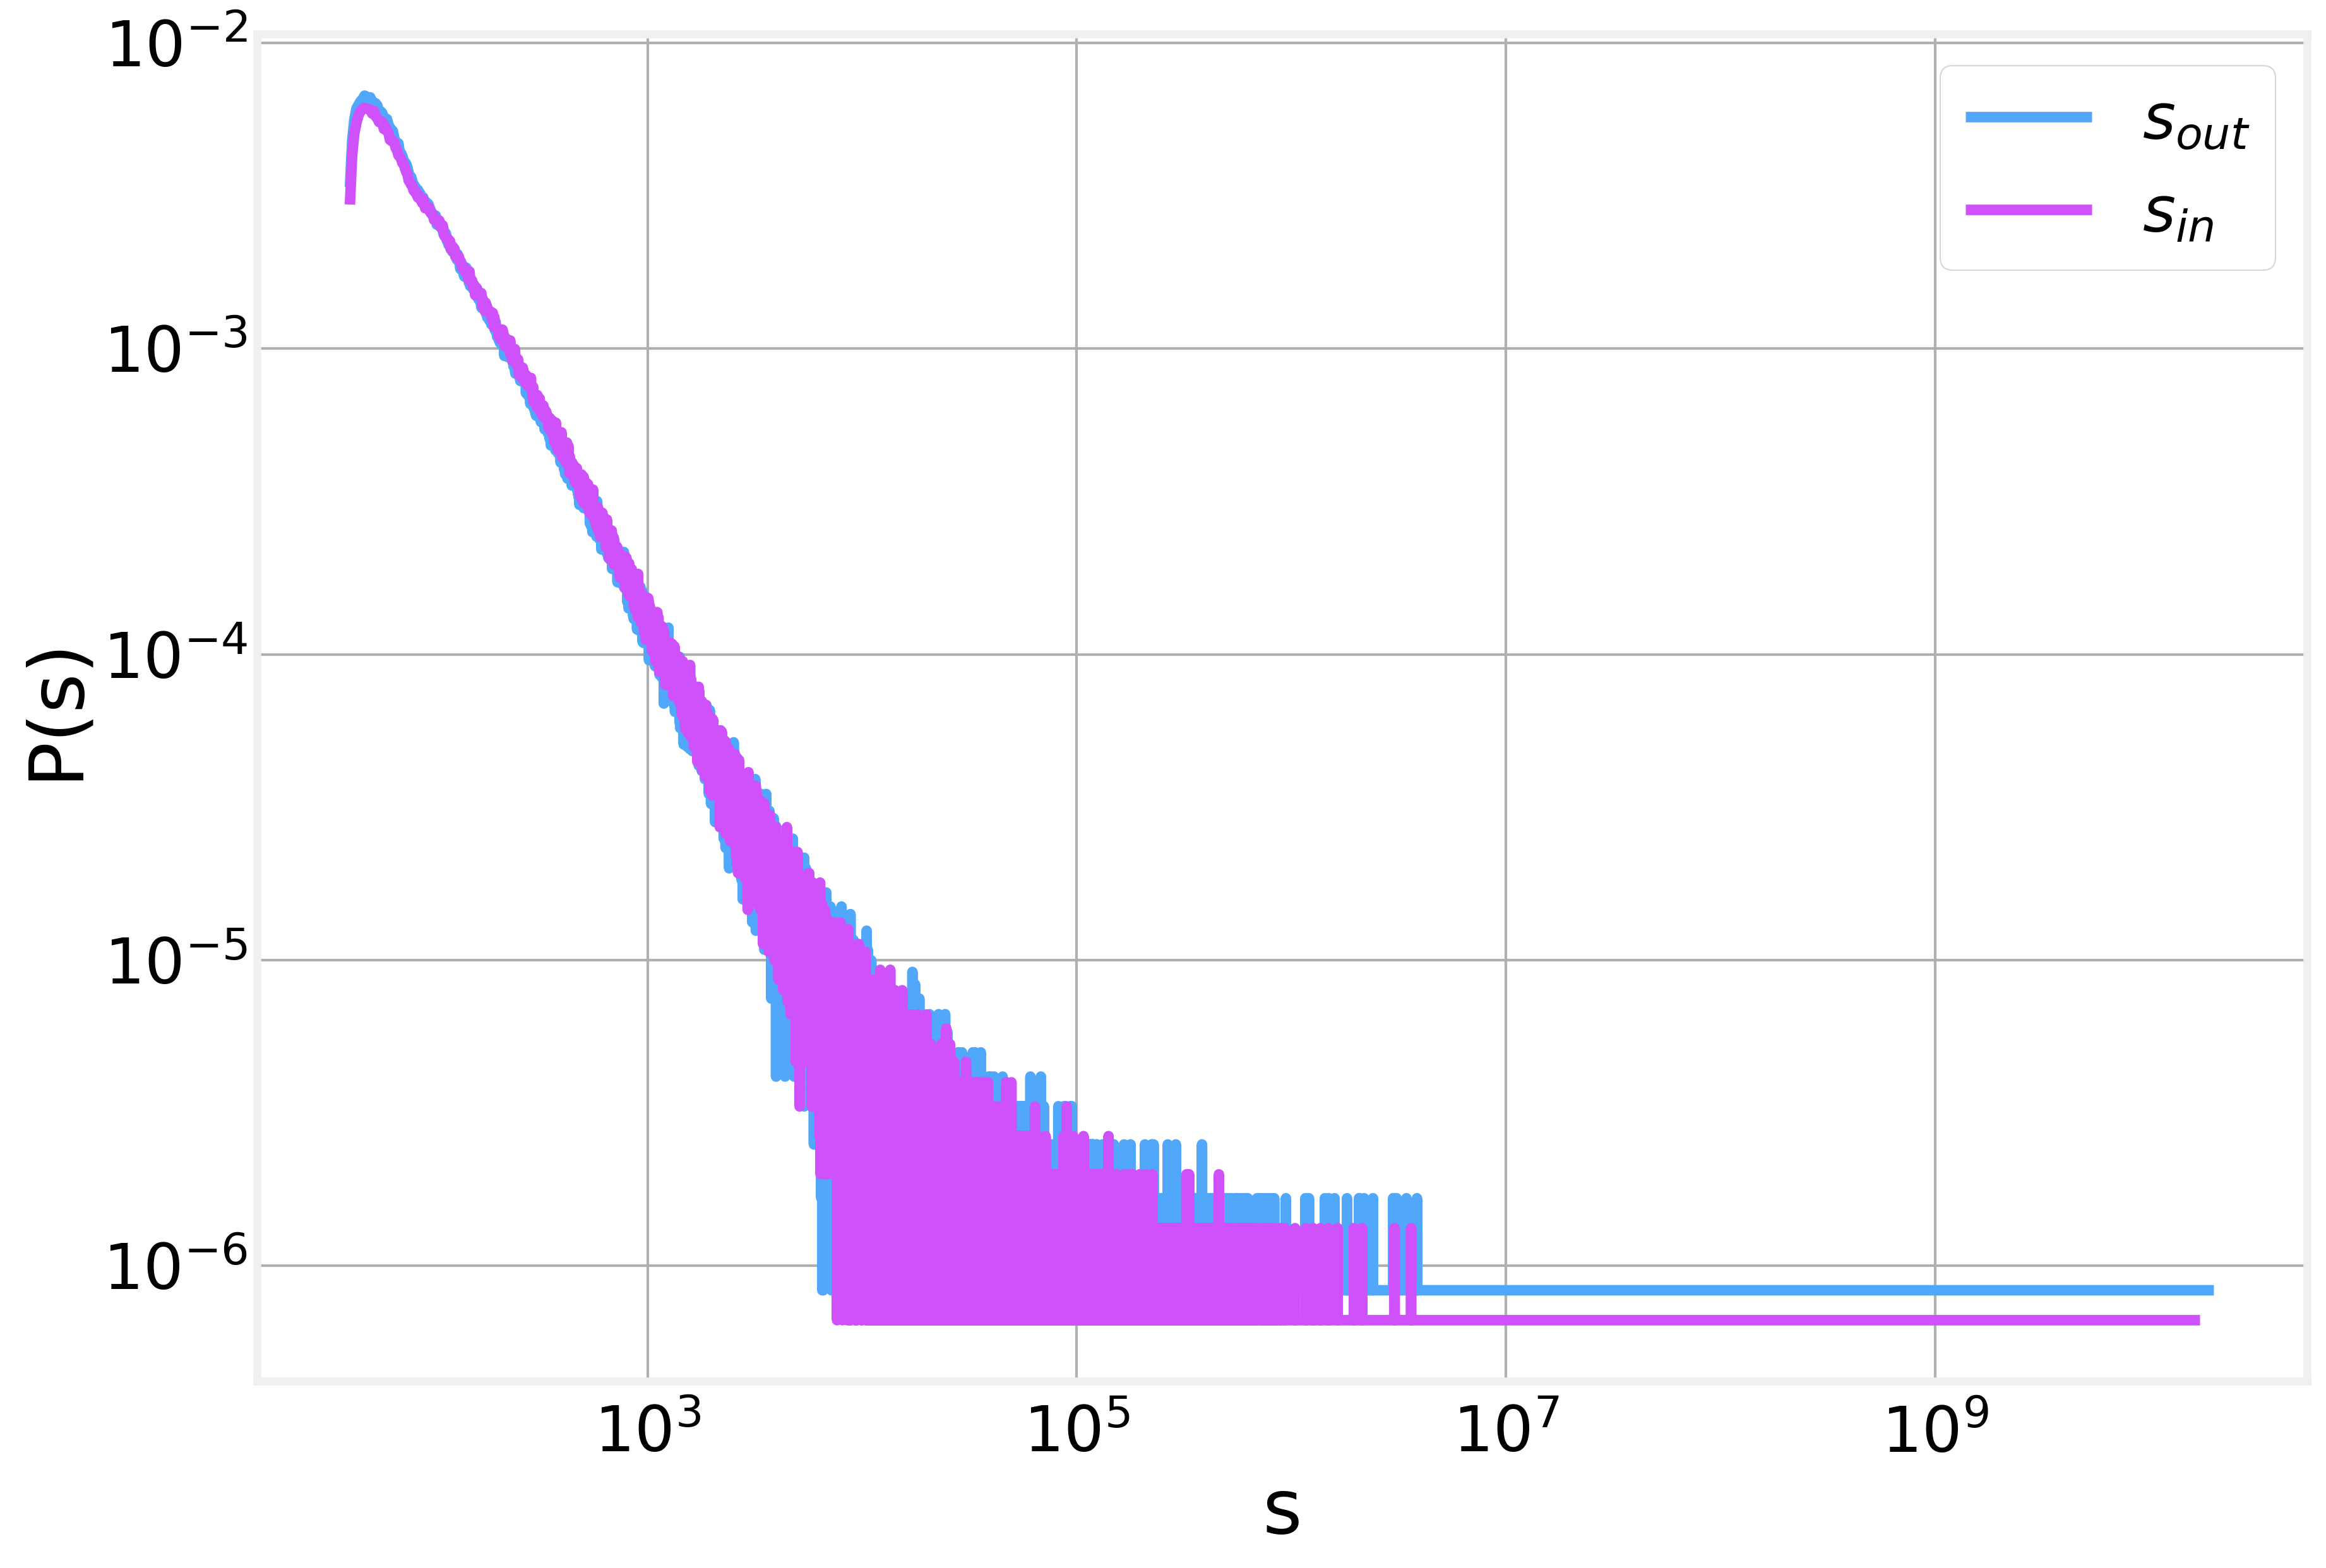

In [45]:
ax = S_out.plot(x=0, y=1, logy=True, logx=True, label=r'$s_{out}$')
S_in.plot(x=0, y=1, logy=True, logx=True, ax=ax, label=r'$s_{in}$')
ax.legend()
ax.set_xlabel('s')
ax.set_ylabel('P(s)')

for label in ax.xaxis.get_majorticklabels():
    label.set_y(-.01)

plt.gcf().tight_layout()

In [46]:
strength_in.columns=['sin']
strength_out.columns=['sout']

In [47]:
node_info = node_info.join(strength_in, how='outer').fillna(1)
node_info = node_info.join(strength_out, how='outer').fillna(1)

In [48]:
corr = node_info.corr()
corr.rename(columns={'kin': r'$k_{in}$', 
                    'sin': r'$s_{in}$',
                    'kout': r'$k_{out}$',
                    'sout': r'$s_{out}$'}, inplace=True)
corr.rename(index={'kin': r'$k_{in}$', 
                    'sin': r'$s_{in}$',
                    'kout': r'$k_{out}$',
                    'sout': r'$s_{out}$'}, inplace=True)

<AxesSubplot:>

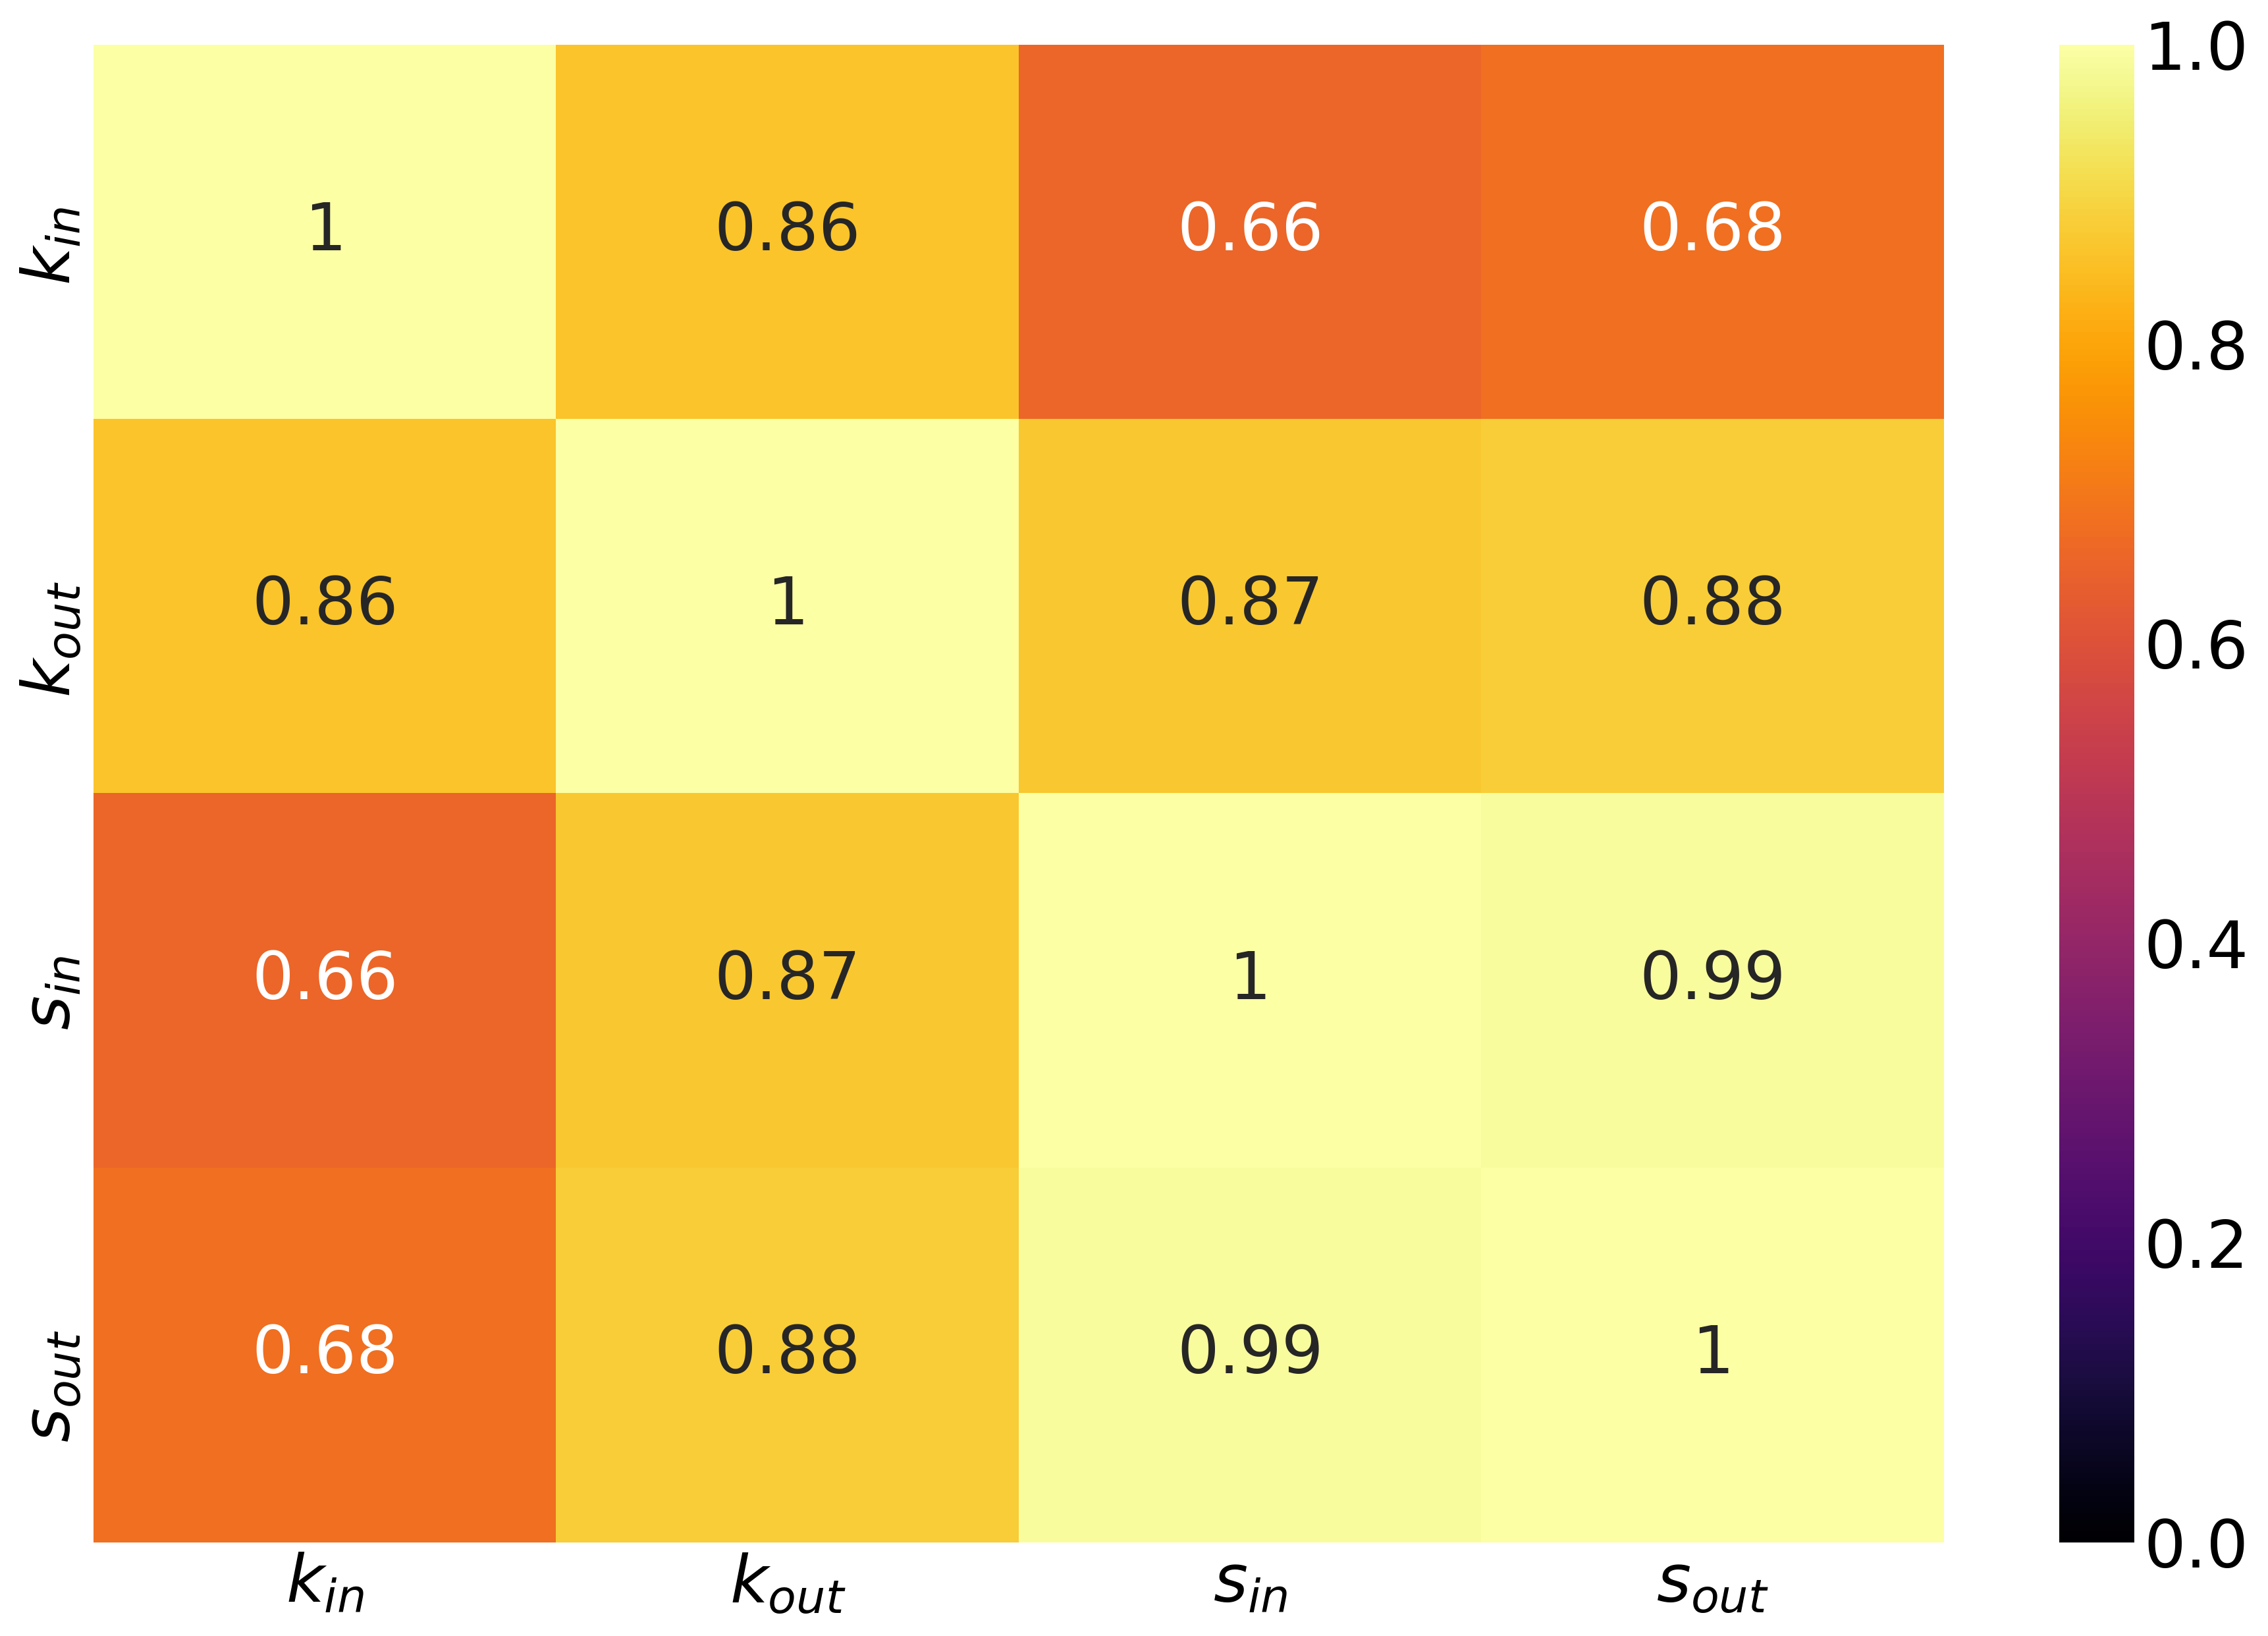

In [49]:
sns.heatmap(corr.round(2), vmin=0, vmax=1, annot=True, cmap=plt.cm.inferno)

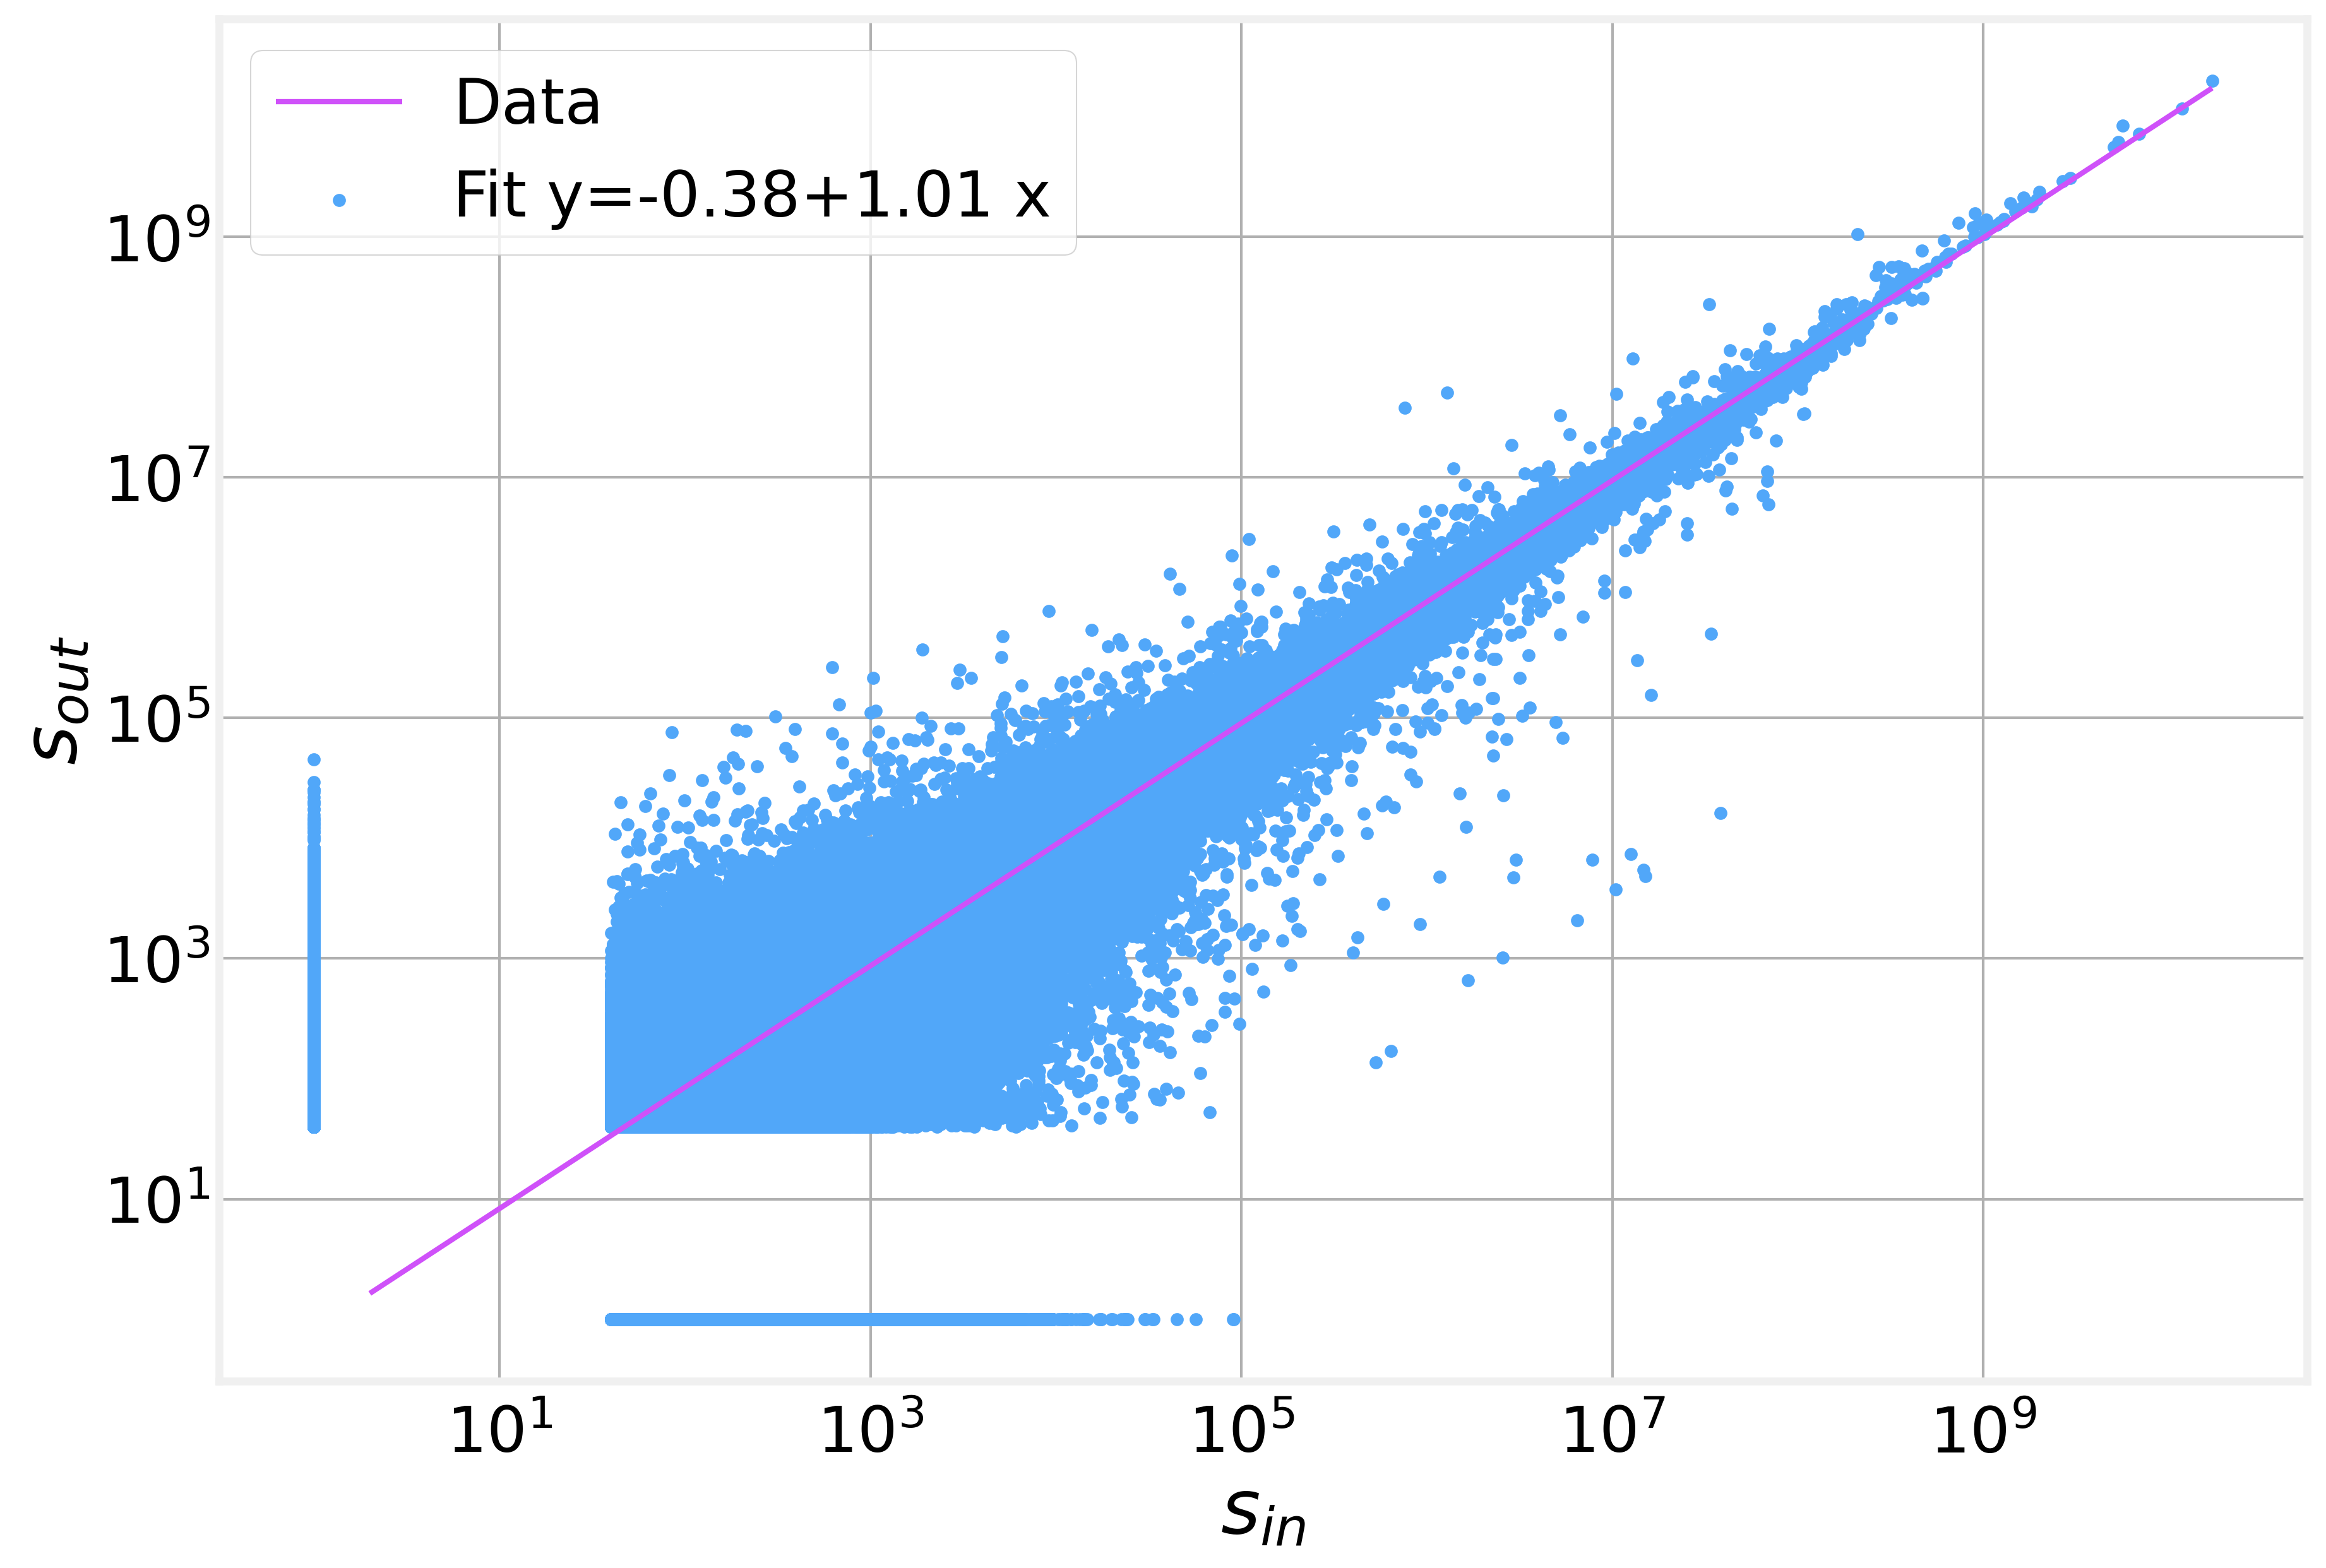

In [50]:
ax = node_info.plot.scatter(x='sin', y='sout')

srange = np.array([node_info[['sin']].max(), node_info[['sin']].min()+1])
pred = lm.predict(srange)
ax.loglog(srange, pred, '-', color=colors[1], lw=2)

ax.set_xlabel(r'$s_{in}$')
ax.set_ylabel(r'$s_{out}$')

for label in ax.xaxis.get_majorticklabels():
    label.set_y(-.01)

ax.legend(['Data', 'Fit y=%1.2f+%1.2f x' % (lm.intercept_[0], lm.coef_[0])])

## Random Walk

We define a utility function to normalize the weights of each out going edges

In [51]:
def normalize(x):
    x['weight'] /= x['weight'].sum()
    return x

And apply it to our edge list to generate a stochastic graph

In [52]:
graph = edges.groupby(['node_i'], as_index=False).progress_apply(normalize)
graph.columns = ['node_i', 'node_j', 'weight']
graph.set_index('node_i', inplace=True)

100%|██████████| 1202233/1202233 [12:31<00:00, 1599.50it/s]


Now we can perform our random walk starting with an arbitrarily chose word, say, "you"

In [53]:
Nsteps = 20
current_word = 'you'

text = [current_word]

for step in tqdm(range(Nsteps), total=Nsteps):
    # Get all the possible nearest neighbors
    neighbors = graph.loc[[current_word]].copy()
        
    # Randomly select the next word
    next_index = np.random.multinomial(1, neighbors['weight'].values.flatten(), size=1).argmax()
    current_word = neighbors.iloc[next_index]['node_j']
    
    # Print the next word in the walk
    text.append(current_word)

100%|██████████| 20/20 [02:05<00:00,  6.29s/it]


The text it generates is not exactly up to Shakespeare standards and it becomes increasingly weird as you demand more and more steps but a simple algorithm like this is already a good start towards a predictive writing system such as the one in your smartphone

In [54]:
print(" ".join(text))

you too many other differences and particulars number of pennsylvania railroad and student couples found tu esto me of aklan and


<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>